# Demonstration of soScope working on Multiomics

This is a demonstration of soScope analysis on spatial ATAC-RNA-seq data with multiomics data (Gaussian and negative binomial distribution).

Bohan Li @ Deng ai Lab @ BUAA 2024.

Software provided as is under MIT License.

## Install dependency software

In [1]:
import os
import sys
import torch
import random

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    
seed_all(0)

## Scene Preset

Experiment: Human skin tissue multiomics resolution enhancement experiment.

Inputs: 1,874 “low-resolution” spots with protien and gene expressions (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), and spatial neighboring relations (A)

Outputs: Profiles of 16,866 “enhanced-resolution” spots.

Genes analyzed : top 25 highly variable genes.

Proteins analyzed : corresponding ATAC peaks.

In [178]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# soScope_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# soScope_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
epochs = [4000, 4000]
two_step_train(logging=not None,
               vgae_experiment_dir='experiments/VGAE_atac',
               soScope_experiment_dir=f'experiments/soScope_atac_{epochs[0]}_{epochs[1]}',
               data_dir='DataSet/ATAC_seq/',
               vgae_config_file='config/MultiomicsGaussian/VGAE.yml',
               soScope_config_file='config/MultiomicsGaussian/soScope.yml',
               device='cuda',
               checkpoint_every=1000,
               backup_every=200,
               epochs=epochs,
               num_neighbors=4)


Step 1
<class 'soScope_model.training.vgae.VGAETrainer_Joint_GNB'>
===There are 1874 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 4 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████| 4000/4000 [00:44<00:00, 90.14it/s] 


Step 2
<class 'soScope_model.training.soScope_model_for_MultiGaussian.soScope_JointGaussian'>
Pretrained Model Loaded!
========== Optimization of soScope ============


100%|██████████| 4000/4000 [43:50<00:00,  1.52it/s]


In [2]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.
epochs = [4000, 4000]
infer(
        experiment_dir=f'experiments/soScope_atac_{epochs[0]}_{epochs[1]}',
        non_negative=False,
        num_neighbors=4,
        data_dir= 'DataSet/ATAC_seq/',
        result_dir='DataSet/ATAC_seq/',
        device='cuda')

<class 'soScope_model.training.soScope_model_for_GNB.soScope_JointGaussian'>
Pretrained Model Loaded!
We built edges between every neighboring 4 nodes
Spatial Data Loaded


In [2]:
# Visualization

# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.
import numpy as np
import pandas as pd
lr_count = np.load(f'DataSet/ATAC_seq/label.npy')
position = pd.read_csv(f'DataSet/ATAC_seq/position_with_center.csv')
y = (-position['col']).tolist()
x = position['row'].tolist()

en_position = pd.read_csv(f'DataSet/ATAC_seq/enhanced_position_with_center.csv')
en_y = (-en_position['col']).tolist()
en_x = en_position['row'].tolist()

hr_count = np.load(f'DataSet/ATAC_seq/infer_subspot.npy')

In [3]:
feature_names = pd.read_csv(f'DataSet/ATAC_seq/count_original.csv', index_col=0).keys().tolist()

In [6]:
df_lr = pd.DataFrame(lr_count, columns=feature_names)
df = pd.DataFrame(hr_count, columns=feature_names)

# Original and enhanced count

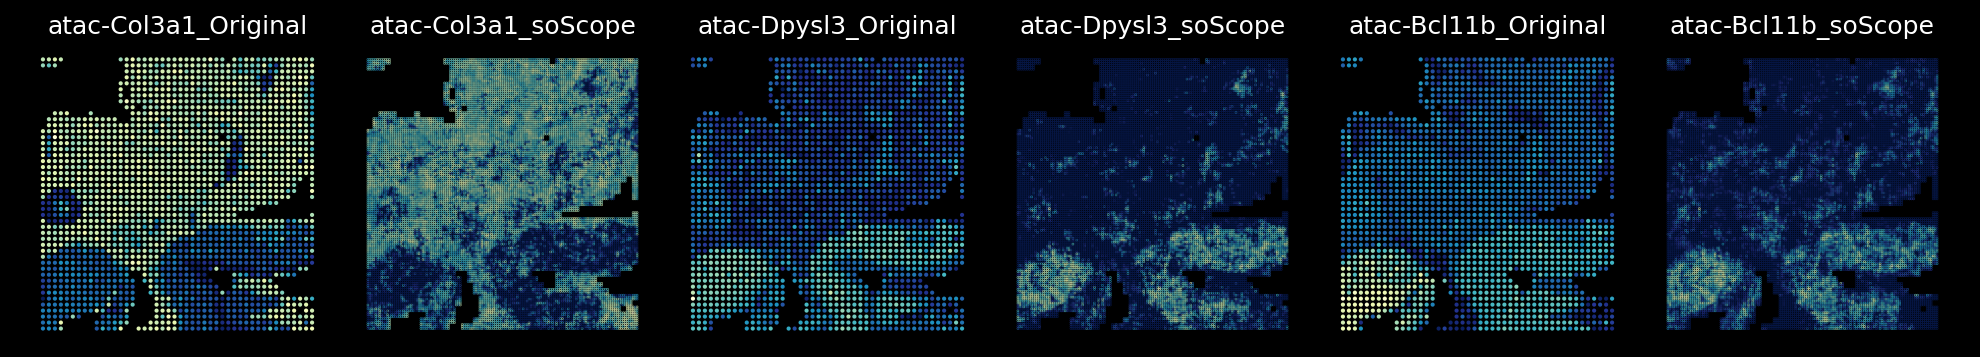

In [11]:
# Simulated resolution enhancement visualization. 
# Visualized data: proteins: HLA, CD71, CD235, and CD146; genes: TMEM132D, CPNE5, RNA18S5, and NMNAT1.
# arrangment in subplot: orginal data (left) at low resolution and scScope (right) predicted data at enhanced resolution
import matplotlib.pyplot as plt

gene_roi = ['Col3a1', 'Dpysl3', 'Bcl11b']
cmap = 'YlGnBu_r'
K = len(gene_roi)
fig = plt.figure(figsize=(13, 2.5*K), dpi=150)
fig.set_facecolor('black')
count = 0
for idx in range(K):
    # merged data visualization
#     gene_name = gene_names[idx]
    peak_name = 'atac-'+gene_roi[idx]
    ax = fig.add_subplot(K,6, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=df_lr[peak_name],
                cmap=cmap
                )
    plt.title(peak_name + '_Original', y=1, color='w')
    
    # soScope predicted data visualization
    ax = fig.add_subplot(K,6, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.05,
                marker='o',
                c=df[peak_name],
                cmap=cmap, vmin=0.3,
                )
    plt.title(peak_name + '_soScope', y=1, color='w')
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

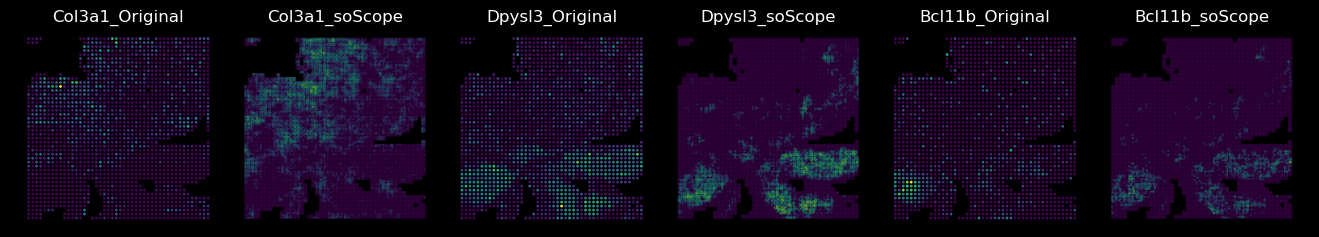

In [12]:
cmap = 'viridis'
K = len(gene_roi)
fig = plt.figure(figsize=(13, 2.5*K), dpi=100)
fig.set_facecolor('black')
count = 0
for idx in range(K):
    # merged data visualization
#     gene_name = gene_names[idx]
    gene_name = gene_roi[idx]
    ax = fig.add_subplot(K,6, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=df_lr[gene_name],
                cmap=cmap
                )
    plt.title(gene_name + '_Original', y=1, color='w')
    
    # soScope predicted data visualization
    ax = fig.add_subplot(K,6, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.05,
                marker='o',
                c=df[gene_name],
                cmap=cmap, vmin=0.5,
                )
    plt.title(gene_name + '_soScope', y=1, color='w')
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

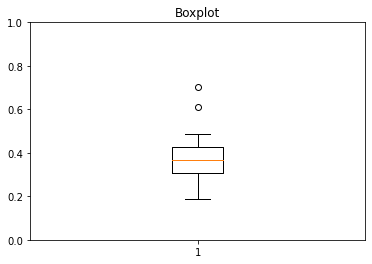

0.3673624753696388


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 生成一组随机数据
from scipy.stats import pearsonr

data_lr = []
for i in range(25):
    pearson_r, _ = pearsonr(lr_count[:, i], lr_count[:, i+25])
    data_lr.append(pearson_r)
    
# 绘制箱线图
plt.boxplot(data_lr)
plt.ylim(0, 1)
# 添加标题
plt.title('Boxplot')

# 显示图形
plt.show()
print(np.median(data_lr))

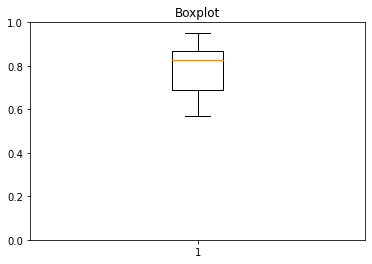

0.8278196212636711


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 生成一组随机数据
from scipy.stats import pearsonr

data_hr = []
bad_genes = []
gene_names = feature_names[25:]
for i in range(25):
    pearson_r, _ = pearsonr(hr_count[:, i], hr_count[:, i+25])
    data_hr.append(pearson_r)
    if pearson_r < 0:
        bad_genes.append(gene_names[i])
        
    
# 绘制箱线图
plt.boxplot(data_hr)
plt.ylim(0, 1)
# 添加标题
plt.title('Boxplot')

# 显示图形
plt.show()
print(np.median(data_hr))

In [15]:
bad_genes

['Ccnd1']

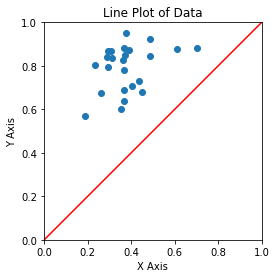

In [13]:
plt.scatter(data_lr, data_hr, marker='o')
y = [0.1*i for i in range(11)]
plt.plot(y, y, linestyle='-', color='r')
plt.title('Pearson correlation comparison')
plt.xlabel('Original')
plt.ylabel('En')
plt.ylim(0, 1)
plt.xlim(0, 1)
# 显示图形
ax = plt.gca()
ax.set_aspect(1)
plt.show()